## Variable that changed a lot

In [1]:
Model_name = "alexnet"

run_num  = "1"         
# It should match the the name of notebook
tensor_baord_variable = Model_name + '_' + run_num

# The path of the best check point
path = f"CheckPoints/{tensor_baord_variable}"

In [2]:
tensor_baord_variable, path

('alexnet_1', 'CheckPoints/alexnet_1')

## Check the working environment

In [3]:
import sys
def is_venv(): return hasattr(sys, 'real_prefix') or sys.base_prefix != sys.prefix

print("sys.base_prefix >> ", sys.base_prefix)
print("sys.prefix >> ", sys.prefix)

print("is_venv():", is_venv())

sys.base_prefix >>  /usr
sys.prefix >>  /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang
is_venv(): True


In [4]:
import os

if os.getenv('VIRTUAL_ENV'):
    print('Using Virtualenv')
else:
    print('Not using Virtualenv')

Using Virtualenv


In [5]:
import sys
import os

print(f'Python Executable: {sys.executable}')
print(f'Python Version: {sys.version}')
print(f'Virtualenv: {os.getenv("VIRTUAL_ENV")}')

Python Executable: /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang/bin/python
Python Version: 3.8.10 (default, May 26 2023, 14:05:08) 
[GCC 9.4.0]
Virtualenv: /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang


## Import libraries

In [6]:
## Import important libraries 

import torch 
from torch import nn 
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

import torchvision
print(torch.__version__)

1.10.0+cu102


In [7]:
# Tune the seed to get the same result for every run for the same parameters
# Remove the randomness in the results 

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

## Check the availabitlity of GPU

In [8]:
# Chech the nvidia compiler driver
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [9]:
# check if CUDA is available

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda" if train_on_gpu else "cpu")


CUDA is available!  Training on GPU ...


In [10]:
# check the device proparities
torch.cuda.get_device_properties(torch.cuda.current_device())

_CudaDeviceProperties(name='Quadro GV100', major=7, minor=0, total_memory=32505MB, multi_processor_count=80)

## Dataset Pre-processing

In [11]:
import os

In [12]:
# This class is used to apply specific transform on  the data 

class InheritedDataset():
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y, images_path = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y, images_path
    
    def __len__(self):
        return len(self.dataset)

In [13]:
# Transformation or Processing for the dataset 

img_size = 224

trans = transforms.Compose([  transforms.Resize(img_size),
                              transforms.CenterCrop(img_size),
                              transforms.ToTensor(),
                            
 ] )

transNoAugment = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),
                                transforms.ToTensor(),
 ] )

In [14]:
# https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

import torch
from torchvision import datasets
from PIL import Image, ImageOps
from typing import Any # , Callable, cast, Dict, List, Optional, Tuple

class ImageFolderWithPaths(datasets.ImageFolder):
    """
    Custom dataset that includes image file paths. 
    Extends for torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        # print('Here')
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
#        print("Hello")
        # print(traindataset)
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [15]:
# "https://stackoverflow.com/questions/12984426/pil-ioerror-image-file-truncated-with-big-images"

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [16]:
def custom_pil_loader(path: str) -> Image.Image:
    """
    This function is used to fix the orientation of the image based on its EXIF data (Exchangeable Image File Format). 
    It handles cases where the image may have been rotated or flipped based on the device or software used to capture it.
    """
    
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    # with open(path, "rb") as f:
    # print("Second")

    with open(path, "rb") as f:
        img = Image.open(f)
    
        fixed_image = ImageOps.exif_transpose(img)
        return fixed_image.convert("RGB")

In [17]:
import sklearn
from sklearn.model_selection import train_test_split

In [18]:
# Assign the batch size and number of workers

batch_size, num_workers  = 64, 32

In [19]:
# Get the data using torch and convert it to tensors

data_dir = "/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version"

dataset = ImageFolderWithPaths(root = data_dir, loader= custom_pil_loader) # transform = transforms.ToTensor())

traindataset, testdataset = InheritedDataset(dataset,trans), InheritedDataset(dataset,transNoAugment)

num_train = len(dataset)
indices = list(range(num_train))

# Data splitting 
# Split the data into training, validation and testing 

X_train, X_test = train_test_split(indices, test_size=0.3, random_state=42 , stratify = dataset.targets , shuffle = True)
X_test_classes = [dataset.targets[i]  for i in X_test]
X_test_after , X_validation = train_test_split(X_test, test_size=0.5, random_state=42,  stratify = X_test_classes , shuffle = True)



train_data = torch.utils.data.Subset(traindataset, indices=X_train)
val_data   = torch.utils.data.Subset(testdataset, indices=X_validation)
test_data  = torch.utils.data.Subset(testdataset, indices=X_test_after)


print(f'Training Data len is ', len(train_data))
print(f'Validation Data len is ', len(val_data))
print(f'Testing Data len is ', len(test_data))

print()

print(f'DataSet len is' , num_train)
print(f'Training Dataset len is' , len(traindataset))
print(f'Testing Dataset len is' , len(testdataset))

# Prepare the loader of the data

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size , num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers= num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size, num_workers = num_workers)

print()
print(f"train_loader size is {len(train_loader)}")
print(f"val_Loader size is {len(val_loader)}")
print(f"test_Loader  size is {len(test_loader)}")

Training Data len is  5499
Validation Data len is  1179
Testing Data len is  1178

DataSet len is 7856
Training Dataset len is 7856
Testing Dataset len is 7856

train_loader size is 86
val_Loader size is 19
test_Loader  size is 19


In [20]:
# Print the index for the dataset for each class 
print(dataset.class_to_idx)

{'Ain': 0, 'Al': 1, 'Alef': 2, 'Beh': 3, 'Dad': 4, 'Dal': 5, 'Feh': 6, 'Ghain': 7, 'Hah': 8, 'Heh': 9, 'Jeem': 10, 'Kaf': 11, 'Khah': 12, 'Laa': 13, 'Lam': 14, 'Meem': 15, 'Noon': 16, 'Qaf': 17, 'Reh': 18, 'Sad': 19, 'Seen': 20, 'Sheen': 21, 'Tah': 22, 'Teh': 23, 'Teh_Marbuta': 24, 'Thal': 25, 'Theh': 26, 'Waw': 27, 'Yeh': 28, 'Zah': 29, 'Zain': 30}


In [21]:
## Print the classes in the dataset 

dataset.classes

['Ain',
 'Al',
 'Alef',
 'Beh',
 'Dad',
 'Dal',
 'Feh',
 'Ghain',
 'Hah',
 'Heh',
 'Jeem',
 'Kaf',
 'Khah',
 'Laa',
 'Lam',
 'Meem',
 'Noon',
 'Qaf',
 'Reh',
 'Sad',
 'Seen',
 'Sheen',
 'Tah',
 'Teh',
 'Teh_Marbuta',
 'Thal',
 'Theh',
 'Waw',
 'Yeh',
 'Zah',
 'Zain']

In [22]:
from torchvision.datasets import ImageFolder

# Get the list of images and their extensions
image_paths = [path for path, _ in dataset.imgs]
image_extensions = set([path.split('.')[-1].lower() for path in image_paths])

# Print the unique image extensions
print("Image Extensions:", image_extensions)

Image Extensions: {'jpg', 'jpeg'}


### Check corrupted images 

In [23]:
import torch
import torchvision.transforms as transforms

def identify_corrupted_images(loader):
    corrupted_images = []
    
    try:
        for batch in loader:
            _, _, image_paths = batch

            # Check if any image in the batch is corrupted
            for i in range(len(image_paths)):
                image_path = image_paths[i]
                
                from PIL import Image

                def is_image_corrupted(image_path):
                    try:
                        with open(image_path, 'rb') as f:
                            Image.open(f)
                        return False
                    except:
                        return True

                corrupted = is_image_corrupted(image_path)
                if corrupted:
                    print("The image is corrupted.")
                else:
                    pass


                corrupted_images.append(image_path)
    
        return corrupted_images
    except:
        print(loader)
# Loop over the train loader and identify corrupted images
corrupted_train_images = identify_corrupted_images(train_loader)

# # Loop over the validation loader and identify corrupted images
# corrupted_val_images = identify_corrupted_images(val_loader)

# # Loop over the test loader and identify corrupted images
# corrupted_test_images = identify_corrupted_images(test_loader)


In [24]:
# def is_image_truncated(image_path):
#     try:
#         # Open the image to check if it's valid
#         with Image.open(image_path) as image:
#             # Check if any operations can be performed on the image without errors
#             image.verify()
#         return False
#     except (OSError, SyntaxError):
#         return True

In [25]:
# import os
# from PIL import Image

# # Specify the root directory containing the subdirectories with images
# root_dir = '/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version'

# # Iterate over the subdirectories and files
# for subdir, dirs, files in os.walk(root_dir):

#     for file in files:
#         # Check if the file is an image (you can add more image file extensions if needed)
#         if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
            
#             # Create the image path
#             image_path = os.path.join(subdir, file)

#             # Open the image using PIL

#             image = Image.open(image_path)

#             if is_image_truncated(image_path):
#                 print(image_path)
#                 print('The image file is truncated.')
#             else:
#                 print(image_path)
#                 # print('The image file is not truncated.')

### Check the images

In [26]:
import matplotlib.pyplot as plt

In [27]:
examples = iter(test_loader)
example_data, example_targets, paths = examples.next()

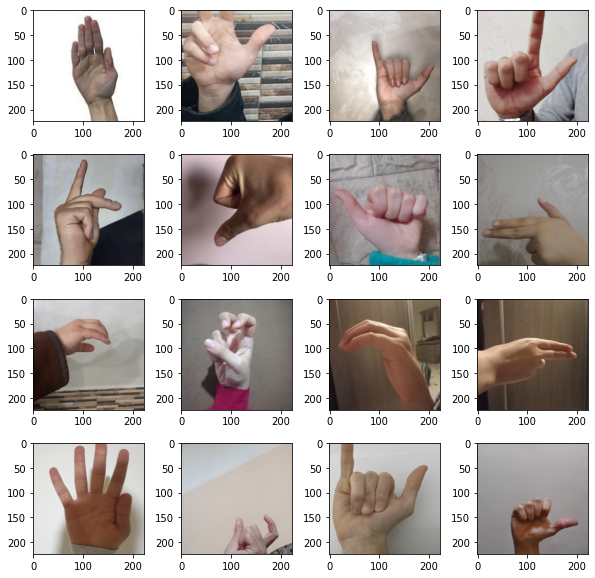

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(example_data[i].permute(1, 2, 0))
    # ax.axis('off')  # Turn off axis labels for each subplot

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust the spacing between subplots

plt.show()

### Add Tensorboard

In [29]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [30]:
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f"runs/{tensor_baord_variable}")

In [31]:
############## TENSORBOARD ########################
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image(
    f'images_{tensor_baord_variable}', img_grid)
writer.close()

In [32]:
%tensorboard --logdir="runs/{tensor_baord_variable}"

UsageError: Line magic function `%tensorboard` not found.


## Data visulization

In [33]:
from collections import Counter
import numpy as np

In [34]:
training_Targets = [] 
validation_Targets = [] 
testing_Targets = [] 

for i in X_train: 
  training_Targets.append(dataset.targets[i])

for i in X_validation: 
  validation_Targets.append(dataset.targets[i])

for i in X_test_after: 
  testing_Targets.append(dataset.targets[i])

In [35]:
C_training   = Counter(training_Targets) 
C_validation = Counter(validation_Targets)
C_testing    = Counter(testing_Targets)

In [36]:
dataset.classes

['Ain',
 'Al',
 'Alef',
 'Beh',
 'Dad',
 'Dal',
 'Feh',
 'Ghain',
 'Hah',
 'Heh',
 'Jeem',
 'Kaf',
 'Khah',
 'Laa',
 'Lam',
 'Meem',
 'Noon',
 'Qaf',
 'Reh',
 'Sad',
 'Seen',
 'Sheen',
 'Tah',
 'Teh',
 'Teh_Marbuta',
 'Thal',
 'Theh',
 'Waw',
 'Yeh',
 'Zah',
 'Zain']

#### Training dataset

Text(0.5, 0, 'Label')

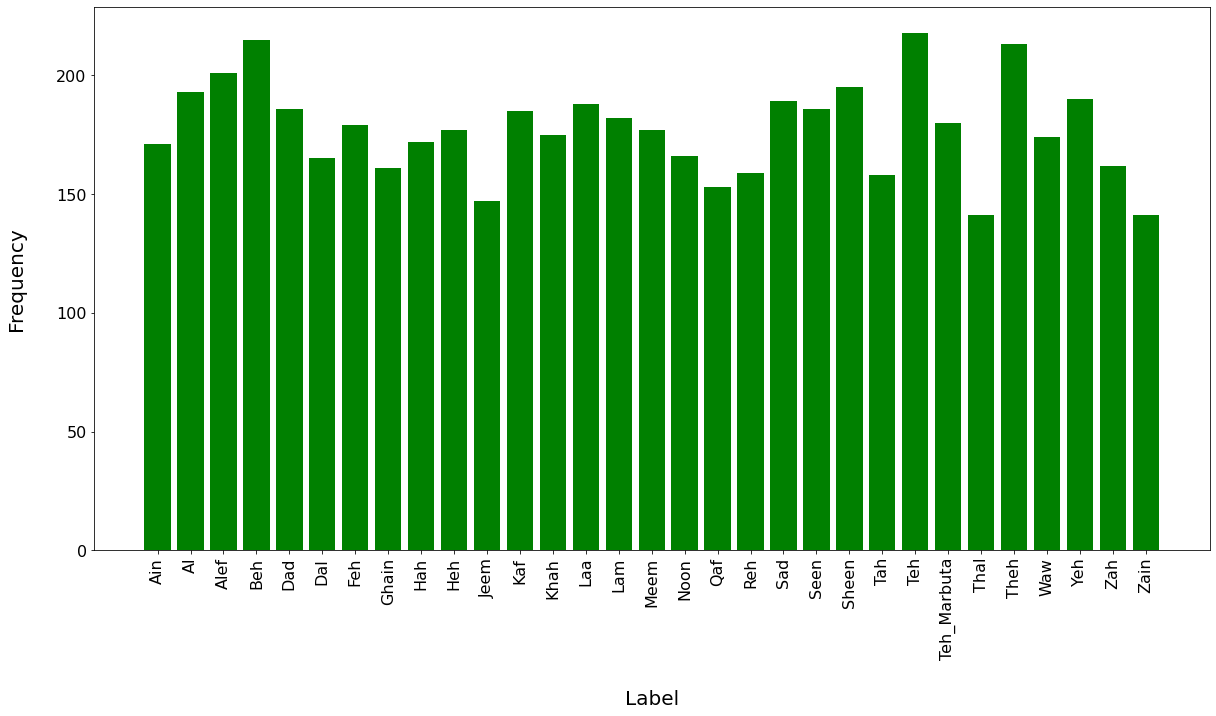

In [37]:
plt.figure(figsize=(20,10))
plt.bar(C_training.keys(), height=C_training.values(), color="green")

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);

plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

#### Validation dataset

Text(0.5, 0, 'Label')

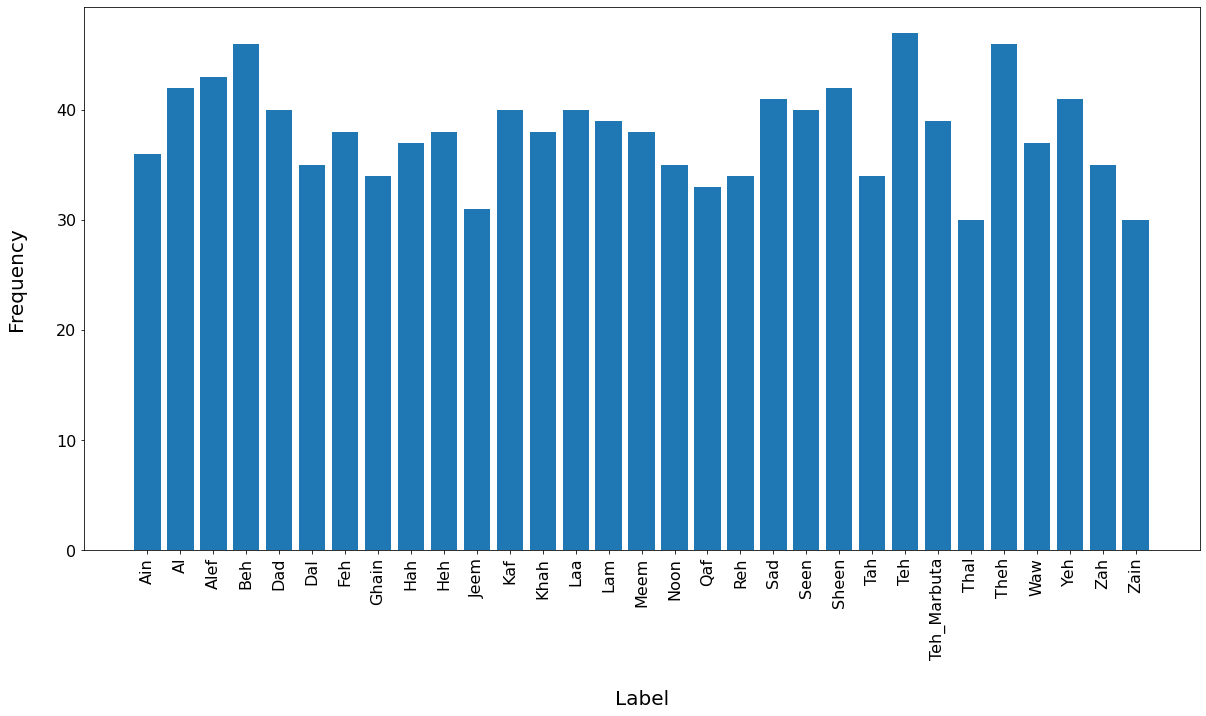

In [38]:
plt.figure(figsize=(20,10))
plt.bar(C_validation.keys(), height=C_validation.values())

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);
plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

#### Testing Dataset

Text(0.5, 0, 'Label')

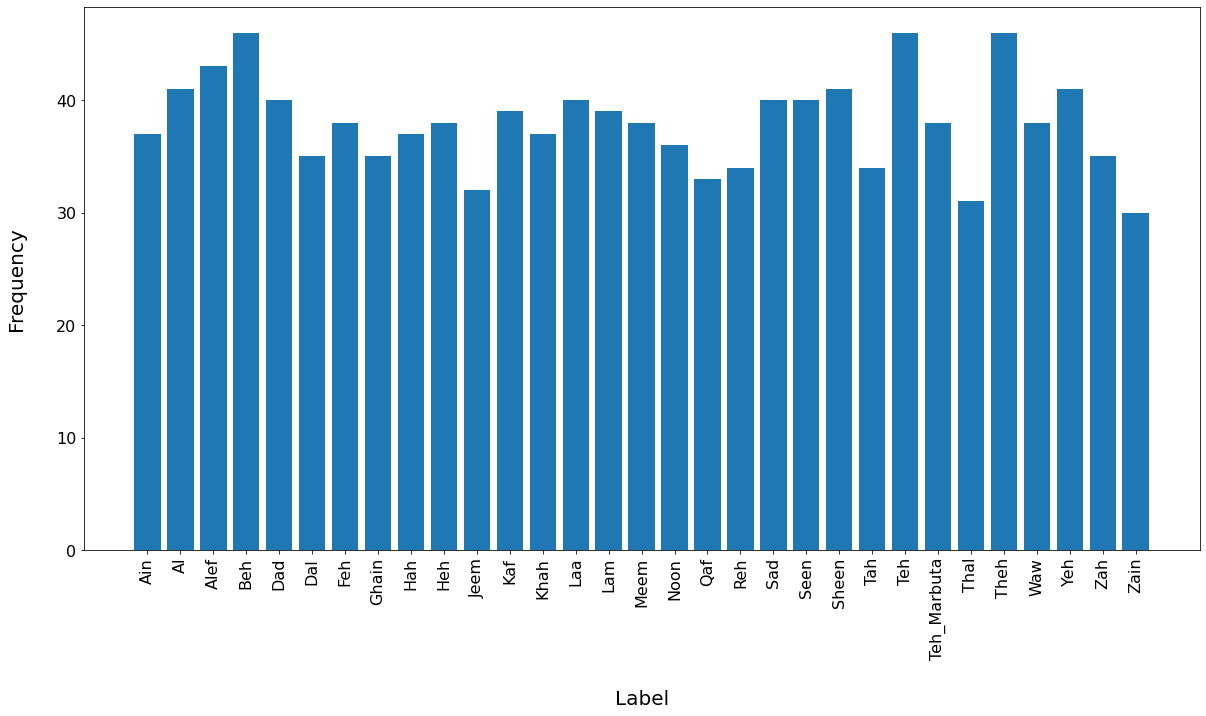

In [39]:
plt.figure(figsize=(20,10))

plt.bar(C_testing.keys(), height=C_testing.values())

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);
plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

## Model Defenition

In [40]:
import torchvision.models as models
import torch.nn.functional as F

In [41]:
# Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/lenovo/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
model = models.alexnet(pretrained=True)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [54]:
model.classifier[6] 

Conv2d(512, 31, kernel_size=(1, 1), stride=(1, 1))

In [55]:
num_of_output_classes = 31
# change the last conv2d layer
model.classifier[6] = nn.Conv2d(512, num_of_output_classes, kernel_size=(1, 1))
# change the internal num_classes variable rather than redefining the forward pass
model.num_classes = num_of_output_classes

In [56]:
model 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [57]:
class Model(nn.Module):

    def __init__(self, in_channels=3, num_class =31 ):
        super(Model, self).__init__()

        self.model = models.alexnet(pretrained=True)
        
#         for param in self.model.parameters():
#             param.requires_grad = False

        num_ftrs = self.model.classifier[6].in_features
        features = list(self.model.classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_ftrs, num_class)])
        self.model.classifier = nn.Sequential(*features)
        print(self.model.classifier[6].out_features)

    def forward(self, x):
        return self.model(x)

model = Model()

31


In [58]:
# Move the model to the device
model.to(device)

Model(
  (model): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): 

### Check the gradient of layers of ResNet-18

In [59]:
for param in model.parameters():
    if not param.requires_grad:
        print("Freezing found on the layers")

## Define a Loss function and optimizer

In [60]:
# Define my Loss 

loss = nn.CrossEntropyLoss()

# Define my optimizer 

params = model.parameters()
optimzer = optim.SGD(params, lr=0.01)

optimzer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

## Model Training & Validation

In [61]:
from tqdm import tqdm 

### Model training & Validation

In [62]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 10

In [63]:
# import EarlyStopping
from pytorchtools import EarlyStopping

In [64]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

In [65]:
All_end_eopch_training_loss = []
All_end_eopch_validation_loss = []

In [66]:
n_epochs = 300
accuracy, best_Acc = 0.0, 0.0, 
print_each_steps = 100
prev_avg_loss = float('inf')
 

# Batch calculations
n_total_steps = len(train_loader)
running_correct, running_loss_val, running_correct_val, training_running_loss = 0, 0.0, 0.0, 0.0

for epoch in range(n_epochs):  # loop over the dataset multiple times
    
    model.train()

    losses_training = [] 
    accuracies_tarining = []

    ###################
    # train the model #
    ###################  
    
    for i, batch in tqdm(enumerate(train_loader, 1),"Epoch # is {}".format(epoch) ,total = len(train_loader),position=0, leave=False):

        inputs, labels, _ = batch 

        # import pdb; pdb.set_trace()
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs) # logits / scores 


        logits = logits.to(device)

        # Calculate loss
        J = loss(logits,labels)

        #  re-initlize gradiants, calculate gradients, update the weights
        optimzer.zero_grad(); J.backward() ; optimzer.step()

        # 
        training_running_loss += J.item()
        # _, predicted = torch.max(logits.data, 1)
        # running_correct += (predicted == labels).sum().item()


        losses_training.append(J.item())

        running_correct += labels.eq(logits.detach().argmax(dim=1)).float().mean()
        accuracies_tarining.append(labels.eq(logits.detach().argmax(dim=1)).float().mean())
    
        # Print some information each "print_each_steps" steps 

        if i%print_each_steps ==0:
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i}/{n_total_steps}], Loss: {J.item():.8f}')
            ############## TENSORBOARD ########################
            writer.add_scalar('Batch_training_loss', training_running_loss / print_each_steps, epoch * n_total_steps + i)
            running_accuracy = running_correct / print_each_steps  # 
            writer.add_scalar('Batch_training_accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            training_running_loss = 0.0
            ###################################################

    # End epoch calculations 
    End_Eopch_Training_Loss = torch.tensor(losses_training).float().mean()
    End_Eopch_Training_Acc  = torch.tensor(accuracies_tarining).float().mean()
  
    
    # Add training loss and training accuracy each epoch 
    writer.add_scalar('End_epoch_training_loss', End_Eopch_Training_Loss.item(),epoch)
    writer.add_scalar('End_epoch_training_accuracy', End_Eopch_Training_Acc.item(),epoch)


    print()
    print(f'Epoch {epoch + 1}/{n_epochs},  Step [{i}/{n_total_steps}]', end = ', ')
    print(f'Avg training loss: { End_Eopch_Training_Loss.item() : .8f}', end = ', ')
    print(f'Avg training accuracy : {End_Eopch_Training_Acc.item() : .8%}')
    print()


    
    
    ######################    
    # validate the model #
    ######################
        
    losses_validation = [] 
    accuracies_validation = []
  

    model.eval()
  
    with torch.no_grad():
        
        for batch in tqdm(val_loader, total = len(val_loader), position=0, leave=False):

            inputs, labels, _ = batch 

            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs) # logits / scores 

            logits = logits.to(device)

            J = loss(logits,labels)


            losses_validation.append(J.item())

            running_loss_val += J.item()
            losses_validation.append(J.item())


            running_correct = labels.eq(logits.detach().argmax(dim=1)).float().mean()
            accuracies_validation.append(labels.eq(logits.detach().argmax(dim=1)).float().mean())
      
        current_loss  = torch.tensor(losses_validation).float().mean()
        current_Accuracy = torch.tensor(accuracies_validation).float().mean()
                  

        writer.add_scalar('End epoch, Validation loss', running_loss_val / len(val_loader), epoch)
        running_accuracy = running_correct / len(val_loader) 
        writer.add_scalar('End epoch, Validation accuracy', running_accuracy, epoch )
        

        print()  
        print(f'Epoch {epoch + 1}', end = ', ')
        print(f'Avg validation loss: {current_loss :.8f}', end = ', ')
        print(f'Avg validation accuracy : {current_Accuracy :.8%}')
        print()



        if current_loss < prev_avg_loss:

            prev_avg_loss = current_loss

            print()
            print('The best validation Loss is ', prev_avg_loss.item())
            print('The Current Accuracy of validation is ', current_Accuracy.item() * 100)
            print()

            torch.save(model.state_dict(), path)
      
        if current_Accuracy > best_Acc :

            best_Acc = current_Accuracy

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(current_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break           
            
        # Add training loss and training accuracy each epoch 
        writer.add_scalar('End_epoch_validation_loss', torch.tensor(losses_validation).float().mean().item(),epoch)
        writer.add_scalar('End_epoch_validation_accuracy', torch.tensor(accuracies_validation).float().mean().item(),epoch)

    # End epoch, training dataset
    All_end_eopch_validation_loss.append(torch.tensor(losses_validation).float().mean().item())
    
    # End epoch, training dataset
    All_end_eopch_training_loss.append(End_Eopch_Training_Loss.item())  
    
    writer.add_scalars('Traning_Validation', {'EOP_training loss':End_Eopch_Training_Loss.item(),
                                            'EOP_Validation loss':torch.tensor(losses_validation).float().mean().item()},
                                             epoch)

    running_loss_val = 0.0 
    running_correct_val = 0
    


Epoch 1/300,  Step [86/86], Avg training loss:  2.46387315, Avg training accuracy :  27.83306837%




Epoch 1, Avg validation loss: 2.29461718, Avg validation accuracy : 28.90472710%


The best validation Loss is  2.294617176055908
The Current Accuracy of validation is  28.90472710132599

Validation loss decreased (inf --> 2.294617).  Saving model ...



Epoch 2/300,  Step [86/86], Avg training loss:  1.39500213, Avg training accuracy :  55.38190603%




Epoch 2, Avg validation loss: 1.00368297, Avg validation accuracy : 67.02607274%


The best validation Loss is  1.0036829710006714
The Current Accuracy of validation is  67.02607274055481

Validation loss decreased (2.294617 --> 1.003683).  Saving model ...



Epoch 3/300,  Step [86/86], Avg training loss:  0.97596544, Avg training accuracy :  68.10455322%




Epoch 3, Avg validation loss: 1.01268363, Avg validation accuracy : 65.45443535%

EarlyStopping counter: 1 out of 10



Epoch 4/300,  Step [86/86], Avg training loss:  0.75785106, Avg training accuracy :  74.40628409%




Epoch 4, Avg validation loss: 0.71471387, Avg validation accuracy : 76.41021013%


The best validation Loss is  0.7147138714790344
The Current Accuracy of validation is  76.41021013259888

Validation loss decreased (1.003683 --> 0.714714).  Saving model ...



Epoch 5/300,  Step [86/86], Avg training loss:  0.62205410, Avg training accuracy :  79.47686911%




Epoch 5, Avg validation loss: 0.64035934, Avg validation accuracy : 78.49659324%


The best validation Loss is  0.6403593420982361
The Current Accuracy of validation is  78.49659323692322

Validation loss decreased (0.714714 --> 0.640359).  Saving model ...



Epoch 6/300,  Step [86/86], Avg training loss:  0.51085246, Avg training accuracy :  83.60114098%




Epoch 6, Avg validation loss: 0.61786956, Avg validation accuracy : 78.90777588%


The best validation Loss is  0.6178695559501648
The Current Accuracy of validation is  78.90777587890625

Validation loss decreased (0.640359 --> 0.617870).  Saving model ...



Epoch 7/300,  Step [86/86], Avg training loss:  0.43534496, Avg training accuracy :  85.28774381%




Epoch 7, Avg validation loss: 0.58506149, Avg validation accuracy : 80.14132977%


The best validation Loss is  0.5850614905357361
The Current Accuracy of validation is  80.14132976531982

Validation loss decreased (0.617870 --> 0.585061).  Saving model ...



Epoch 8/300,  Step [86/86], Avg training loss:  0.38092422, Avg training accuracy :  87.50585318%




Epoch 8, Avg validation loss: 0.47645548, Avg validation accuracy : 84.74659324%


The best validation Loss is  0.4764554798603058
The Current Accuracy of validation is  84.74659323692322

Validation loss decreased (0.585061 --> 0.476455).  Saving model ...



Epoch 9/300,  Step [86/86], Avg training loss:  0.34034932, Avg training accuracy :  88.83216381%




Epoch 9, Avg validation loss: 0.53042871, Avg validation accuracy : 83.64704847%

EarlyStopping counter: 1 out of 10



Epoch 10/300,  Step [86/86], Avg training loss:  0.27621004, Avg training accuracy :  90.94278812%




Epoch 10, Avg validation loss: 0.48258737, Avg validation accuracy : 84.72526670%

EarlyStopping counter: 2 out of 10



Epoch 11/300,  Step [86/86], Avg training loss:  0.24945079, Avg training accuracy :  91.57869220%




Epoch 11, Avg validation loss: 0.49430677, Avg validation accuracy : 85.76388955%

EarlyStopping counter: 3 out of 10



Epoch 12/300,  Step [86/86], Avg training loss:  0.19797689, Avg training accuracy :  93.94523501%




Epoch 12, Avg validation loss: 0.51339680, Avg validation accuracy : 84.31408405%

EarlyStopping counter: 4 out of 10



Epoch 13/300,  Step [86/86], Avg training loss:  0.23282227, Avg training accuracy :  92.38119721%




Epoch 13, Avg validation loss: 0.49472788, Avg validation accuracy : 84.99330282%

EarlyStopping counter: 5 out of 10



Epoch 14/300,  Step [86/86], Avg training loss:  0.15639038, Avg training accuracy :  95.08832097%




Epoch 14, Avg validation loss: 0.47139433, Avg validation accuracy : 85.92836261%


The best validation Loss is  0.4713943302631378
The Current Accuracy of validation is  85.92836260795593

Validation loss decreased (0.476455 --> 0.471394).  Saving model ...



Epoch 15/300,  Step [86/86], Avg training loss:  0.14319290, Avg training accuracy :  94.89462376%




Epoch 15, Avg validation loss: 0.46087939, Avg validation accuracy : 85.95882058%


The best validation Loss is  0.460879385471344
The Current Accuracy of validation is  85.95882058143616

Validation loss decreased (0.471394 --> 0.460879).  Saving model ...



Epoch 16/300,  Step [86/86], Avg training loss:  0.13624892, Avg training accuracy :  95.71066499%




Epoch 16, Avg validation loss: 0.46193087, Avg validation accuracy : 86.94566488%

EarlyStopping counter: 1 out of 10



Epoch 17/300,  Step [86/86], Avg training loss:  0.10374948, Avg training accuracy :  96.78261280%




Epoch 17, Avg validation loss: 0.45159596, Avg validation accuracy : 87.35684752%


The best validation Loss is  0.4515959620475769
The Current Accuracy of validation is  87.35684752464294

Validation loss decreased (0.460879 --> 0.451596).  Saving model ...



Epoch 18/300,  Step [86/86], Avg training loss:  0.10406210, Avg training accuracy :  96.56305313%




Epoch 18, Avg validation loss: 0.47625741, Avg validation accuracy : 87.22283244%

EarlyStopping counter: 1 out of 10



Epoch 19/300,  Step [86/86], Avg training loss:  0.09666734, Avg training accuracy :  96.99602127%




Epoch 19, Avg validation loss: 0.46742162, Avg validation accuracy : 87.35684752%

EarlyStopping counter: 2 out of 10



Epoch 20/300,  Step [86/86], Avg training loss:  0.08894587, Avg training accuracy :  96.98401093%




Epoch 20, Avg validation loss: 0.45947480, Avg validation accuracy : 87.76803017%

EarlyStopping counter: 3 out of 10



Epoch 21/300,  Step [86/86], Avg training loss:  0.08577809, Avg training accuracy :  97.49858975%




Epoch 21, Avg validation loss: 0.54182142, Avg validation accuracy : 85.05421877%

EarlyStopping counter: 4 out of 10



Epoch 22/300,  Step [86/86], Avg training loss:  0.08294088, Avg training accuracy :  97.60019779%




Epoch 22, Avg validation loss: 0.45025364, Avg validation accuracy : 87.52132058%


The best validation Loss is  0.4502536356449127
The Current Accuracy of validation is  87.52132058143616

Validation loss decreased (0.451596 --> 0.450254).  Saving model ...



Epoch 23/300,  Step [86/86], Avg training loss:  0.06859875, Avg training accuracy :  98.09229374%




Epoch 23, Avg validation loss: 0.49612141, Avg validation accuracy : 86.91520691%

EarlyStopping counter: 1 out of 10



Epoch 24/300,  Step [86/86], Avg training loss:  0.06284932, Avg training accuracy :  98.34358096%




Epoch 24, Avg validation loss: 0.47378504, Avg validation accuracy : 87.40862608%

EarlyStopping counter: 2 out of 10



Epoch 25/300,  Step [86/86], Avg training loss:  0.06352045, Avg training accuracy :  98.03624749%




Epoch 25, Avg validation loss: 0.48270902, Avg validation accuracy : 87.38730550%

EarlyStopping counter: 3 out of 10



Epoch 26/300,  Step [86/86], Avg training loss:  0.04816845, Avg training accuracy :  98.76453280%




Epoch 26, Avg validation loss: 0.48294705, Avg validation accuracy : 87.98428774%

EarlyStopping counter: 4 out of 10



Epoch 27/300,  Step [86/86], Avg training loss:  0.05030121, Avg training accuracy :  98.79933000%




Epoch 27, Avg validation loss: 0.44814852, Avg validation accuracy : 89.11427855%


The best validation Loss is  0.4481485188007355
The Current Accuracy of validation is  89.11427855491638

Validation loss decreased (0.450254 --> 0.448149).  Saving model ...



Epoch 28/300,  Step [86/86], Avg training loss:  0.04503353, Avg training accuracy :  98.71003032%




Epoch 28, Avg validation loss: 0.47878194, Avg validation accuracy : 88.75487447%

EarlyStopping counter: 1 out of 10



Epoch 29/300,  Step [86/86], Avg training loss:  0.04333851, Avg training accuracy :  98.79624844%




Epoch 29, Avg validation loss: 0.59399492, Avg validation accuracy : 84.69481468%

EarlyStopping counter: 2 out of 10



Epoch 30/300,  Step [86/86], Avg training loss:  0.04569288, Avg training accuracy :  98.71003032%




Epoch 30, Avg validation loss: 0.48197314, Avg validation accuracy : 88.01474571%

EarlyStopping counter: 3 out of 10



Epoch 31/300,  Step [86/86], Avg training loss:  0.03326384, Avg training accuracy :  99.16269779%




Epoch 31, Avg validation loss: 0.46474132, Avg validation accuracy : 88.78533244%

EarlyStopping counter: 4 out of 10



Epoch 32/300,  Step [86/86], Avg training loss:  0.03436268, Avg training accuracy :  99.14607406%




Epoch 32, Avg validation loss: 0.47193131, Avg validation accuracy : 88.94980550%

EarlyStopping counter: 5 out of 10



Epoch 33/300,  Step [86/86], Avg training loss:  0.03664587, Avg training accuracy :  98.92805219%




Epoch 33, Avg validation loss: 0.47305322, Avg validation accuracy : 88.86756897%

EarlyStopping counter: 6 out of 10



Epoch 34/300,  Step [86/86], Avg training loss:  0.03117131, Avg training accuracy :  99.16424155%




Epoch 34, Avg validation loss: 0.44347292, Avg validation accuracy : 88.94980550%


The best validation Loss is  0.4434729218482971
The Current Accuracy of validation is  88.94980549812317

Validation loss decreased (0.448149 --> 0.443473).  Saving model ...



Epoch 35/300,  Step [86/86], Avg training loss:  0.03479074, Avg training accuracy :  99.01735187%




Epoch 35, Avg validation loss: 0.44819090, Avg validation accuracy : 88.78533244%

EarlyStopping counter: 1 out of 10



Epoch 36/300,  Step [86/86], Avg training loss:  0.03760842, Avg training accuracy :  98.96131158%




Epoch 36, Avg validation loss: 0.47214097, Avg validation accuracy : 88.62085938%

EarlyStopping counter: 2 out of 10



Epoch 37/300,  Step [86/86], Avg training loss:  0.03315994, Avg training accuracy :  98.98256063%




Epoch 37, Avg validation loss: 0.48571387, Avg validation accuracy : 88.45638633%

EarlyStopping counter: 3 out of 10



Epoch 38/300,  Step [86/86], Avg training loss:  0.04183340, Avg training accuracy :  98.79933000%




Epoch 38, Avg validation loss: 0.48037389, Avg validation accuracy : 88.29191327%

EarlyStopping counter: 4 out of 10



Epoch 39/300,  Step [86/86], Avg training loss:  0.02691612, Avg training accuracy :  99.23691750%




Epoch 39, Avg validation loss: 0.46769032, Avg validation accuracy : 89.27875161%

EarlyStopping counter: 5 out of 10



Epoch 40/300,  Step [86/86], Avg training loss:  0.02734083, Avg training accuracy :  99.34592843%




Epoch 40, Avg validation loss: 0.45585251, Avg validation accuracy : 89.36098814%

EarlyStopping counter: 6 out of 10



Epoch 41/300,  Step [86/86], Avg training loss:  0.02729915, Avg training accuracy :  99.21875000%




Epoch 41, Avg validation loss: 0.47719488, Avg validation accuracy : 89.11427855%

EarlyStopping counter: 7 out of 10



Epoch 42/300,  Step [86/86], Avg training loss:  0.02305444, Avg training accuracy :  99.32621717%




Epoch 42, Avg validation loss: 0.50092107, Avg validation accuracy : 87.60355711%

EarlyStopping counter: 8 out of 10



Epoch 43/300,  Step [86/86], Avg training loss:  0.01948263, Avg training accuracy :  99.49128032%




Epoch 43, Avg validation loss: 0.48035502, Avg validation accuracy : 88.81579041%

EarlyStopping counter: 9 out of 10



Epoch 44/300,  Step [86/86], Avg training loss:  0.02296640, Avg training accuracy :  99.47311282%




Epoch 44, Avg validation loss: 0.48594621, Avg validation accuracy : 88.09698224%

EarlyStopping counter: 10 out of 10
Early stopping


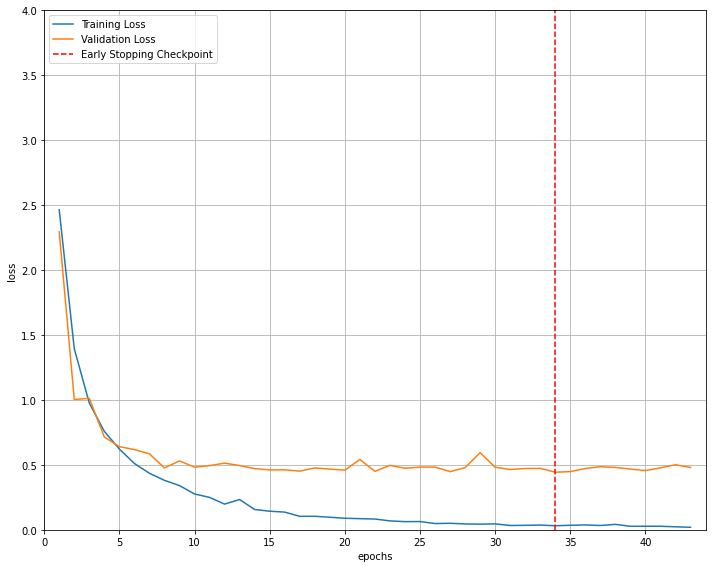

In [67]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(All_end_eopch_training_loss)+1),All_end_eopch_training_loss, label='Training Loss')
plt.plot(range(1,len(All_end_eopch_validation_loss)+1),All_end_eopch_validation_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = All_end_eopch_validation_loss.index(min(All_end_eopch_validation_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 4) # consistent scale
plt.xlim(0, len(All_end_eopch_training_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

## Model testing

In [68]:
model = Model().to(device)
model.load_state_dict(torch.load(path))

print("path >> ", path)

31
path >>  CheckPoints/alexnet_1


### Testing loop

In [69]:
fault_images = []
count = 0 

true = []
pred = []
pred_wrong = []
true_wrong = []
image = [] 

In [70]:
losses_testing = [] 
accuracies_testing = []
labels_list = [] 
logits_list = [] 

model.eval()

index = 0

with torch.no_grad():

    for i,batch in tqdm(enumerate(test_loader, 1), total = len(test_loader), position=0, leave=False):
        
        
        inputs, labels, paths = batch

        inputs = inputs.to(device)
    
        labels = labels.to(device)

        logits = model(inputs) # logits / scores 

        labels_list.append(labels.cpu().detach().numpy())
        logits_list.append(logits.cpu().detach().argmax(dim=1).numpy())

        predicted_labels = logits.cpu().detach().argmax(dim=1).numpy() # list of indices
        logits = logits.to(device)

        J = loss(logits,labels)


        loss_every_batch = J.item()
        losses_testing.append(loss_every_batch)
        

        acc = labels.eq(logits.detach().argmax(dim=1)).float().mean()
        check_it = (logits.detach().argmax(dim=1) != labels).nonzero()

     
        if len(check_it) != 0:
            idicies = check_it.cpu().numpy()
            
            for idx in idicies:
                for ele in idx:
                    fault_images.append([inputs[ele], predicted_labels[ele], labels[ele].item(), paths[ele]])
                    count += 1

        accuracies_testing.append(acc)      
        
        
        
        for i in range(len(predicted_labels)):
            pred.append(predicted_labels[i])
            true.append(labels[i].item())
            if(predicted_labels[i]!=labels[i]):
                pred_wrong.append(predicted_labels[i])
                true_wrong.append(labels[i].item())

        writer.add_scalar("Batch, Testing, loss",loss_every_batch, i)
        writer.add_scalar("Batch, Testing, accuracy",acc, i)

    print()
    print(f'Avg testing loss: {torch.tensor(losses_testing).mean():.5f}', end = ', ')
    print(f'Avg testing accuracy : {torch.tensor(accuracies_testing).float().mean()*100}%')
    print()


Avg testing loss: 0.39565, Avg testing accuracy : 88.99291229248047%



In [71]:
from sklearn import metrics


In [72]:
def performance_matrix(true,pred, type_met):
    precision = metrics.precision_score(true,pred,average=type_met)
    recall = metrics.recall_score(true,pred,average=type_met)
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average=type_met)
    print('Confusion Matrix:\n',metrics.confusion_matrix(true, pred))
    print('Precision: {} \n Recall: {}, \n Accuracy: {}: ,\n f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [73]:
performance_matrix(true,pred, 'macro')

Confusion Matrix:
 [[36  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 37  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0
   0  0  0  0  1  0  0]
 [ 0  0 41  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 40  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  2
   1  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  2  0  0]
 [ 0  0  0  0  1 28  0  0  1  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0
   0  3  0  0  0  0  0]
 [ 0  0  0  0  1  0 28  0  0  2  0  0  1  0  1  0  0  3  0  1  0  0  0  0
   1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0 33  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0 35  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 35  0  0  0  0  0  0  0  2  0  0  0  0  0  0
   1  0  0  0  0  0  0]
 

In [74]:
performance_matrix(true,pred, 'micro')

Confusion Matrix:
 [[36  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 37  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0
   0  0  0  0  1  0  0]
 [ 0  0 41  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 40  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  2
   1  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  2  0  0]
 [ 0  0  0  0  1 28  0  0  1  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0
   0  3  0  0  0  0  0]
 [ 0  0  0  0  1  0 28  0  0  2  0  0  1  0  1  0  0  3  0  1  0  0  0  0
   1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0 33  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0 35  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 35  0  0  0  0  0  0  0  2  0  0  0  0  0  0
   1  0  0  0  0  0  0]
 

In [75]:
performance_matrix(true,pred, None)

Confusion Matrix:
 [[36  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 37  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0
   0  0  0  0  1  0  0]
 [ 0  0 41  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 40  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  2
   1  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  2  0  0]
 [ 0  0  0  0  1 28  0  0  1  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0
   0  3  0  0  0  0  0]
 [ 0  0  0  0  1  0 28  0  0  2  0  0  1  0  1  0  0  3  0  1  0  0  0  0
   1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0 33  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0 35  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 35  0  0  0  0  0  0  0  2  0  0  0  0  0  0
   1  0  0  0  0  0  0]
 

In [76]:
performance_matrix(true,pred, "weighted")

Confusion Matrix:
 [[36  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 37  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0
   0  0  0  0  1  0  0]
 [ 0  0 41  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 40  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  2
   1  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  2  0  0]
 [ 0  0  0  0  1 28  0  0  1  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0
   0  3  0  0  0  0  0]
 [ 0  0  0  0  1  0 28  0  0  2  0  0  1  0  1  0  0  3  0  1  0  0  0  0
   1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0 33  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0 35  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 35  0  0  0  0  0  0  0  2  0  0  0  0  0  0
   1  0  0  0  0  0  0]
 

In [77]:
count

128

In [78]:
len(fault_images)
# , predicted_labels[ele], labels[ele].item()

128

In [79]:
traindataset.dataset.class_to_idx ;
idx2label = {idx:val for val, idx in traindataset.dataset.class_to_idx.items()}

In [80]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [81]:
!ls

 ArSL_Journal_alexnet_SGD.ipynb       CM_Resnet_18_1	    __pycache__
 ArSL_Journal_Resnet18_1.ipynb	      CM_Resnet_18_2	    pytorchtools.py
 ArSL_Journal_Resnet18_2.ipynb	      CM_Resnet_18_3	    requirements.txt
 ArSL_Journal_Resnet18_SGD_01.ipynb  'Final Data Version'   runs
 checkpoint.pt			      images
 CheckPoints			      loss_plot.png


### Print fault images

In [82]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images):
    name_image = f"P_{idx2label[fault_images[i][1]]}_T_{idx2label[fault_images[i][2]]}_{i}.png"
    print(name_image)
    print(fault_images[i][3])
    # plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    # plt.savefig("images/" + name_image, format="png", bbox_inches='tight') # , dpi=400
    # plt.title(name_image)


P_Dal_T_Al_0.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Al/Al_127.jpg
P_Dal_T_Thal_1.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Thal/thal_169.jpg
P_Teh_Marbuta_T_Beh_2.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Beh/Beh_139.jpeg
P_Noon_T_Reh_3.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Reh/Reh_99.jpeg
P_Thal_T_Zain_4.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Zain/Zain_50.jpg
P_Heh_T_Qaf_5.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Qaf/Qaf_145.jpg
P_Yeh_T_Lam_6.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Lam/Lam_254.jpg
P_Teh_T_Theh_7.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/J

<Figure size 1224x1224 with 0 Axes>

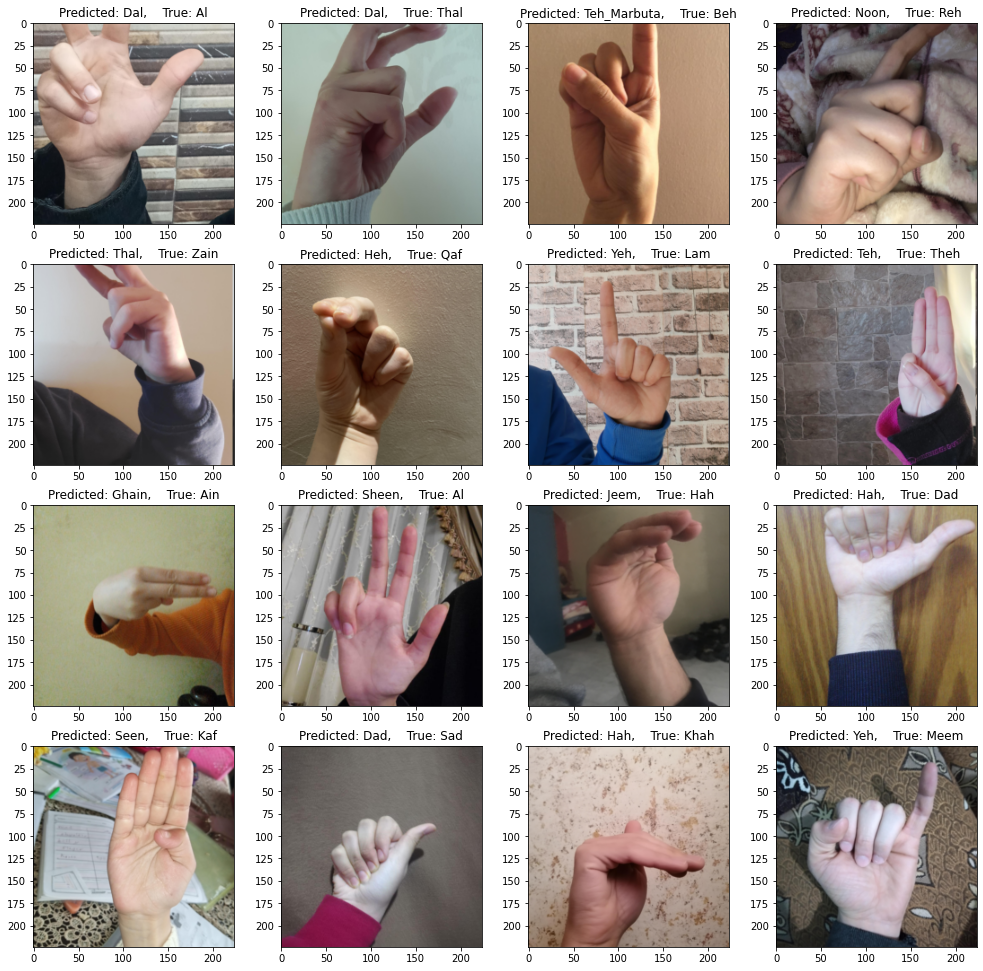

In [83]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[0:16]):
    plt.subplot(4,4,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


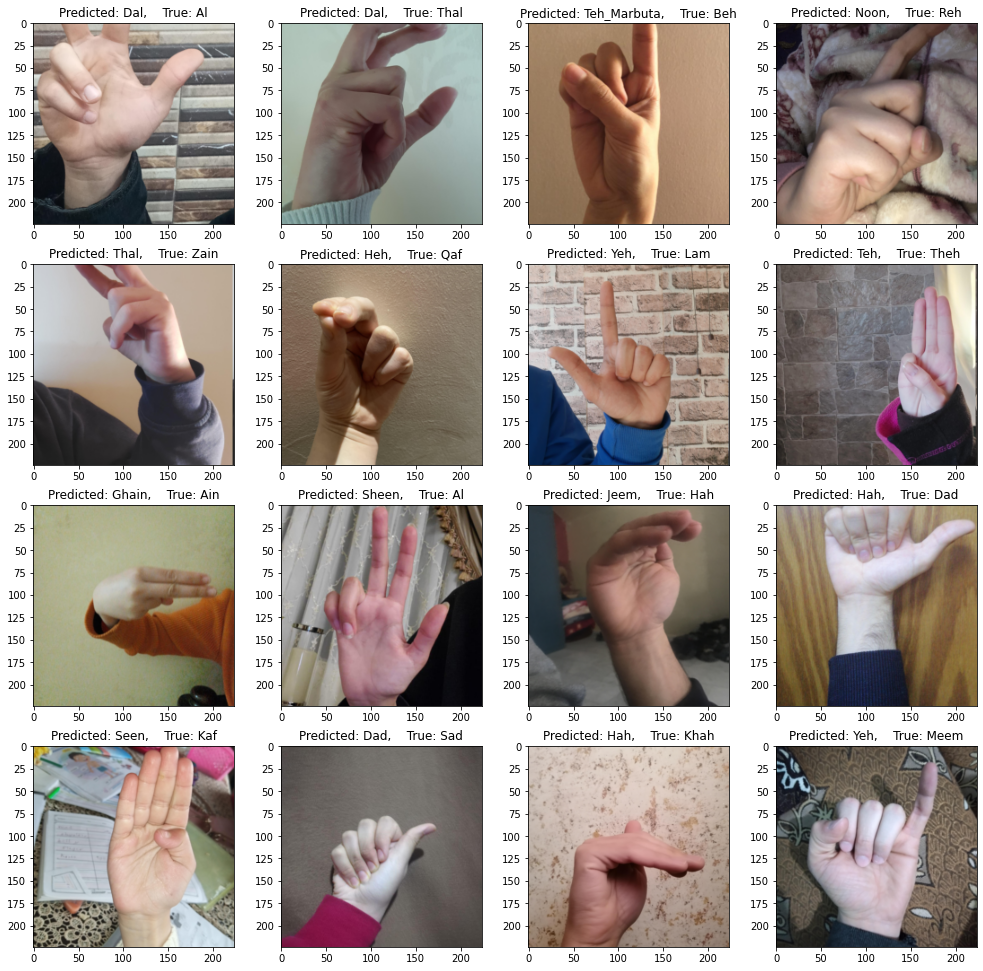

In [84]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[16:32]):
    plt.subplot(4,4,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


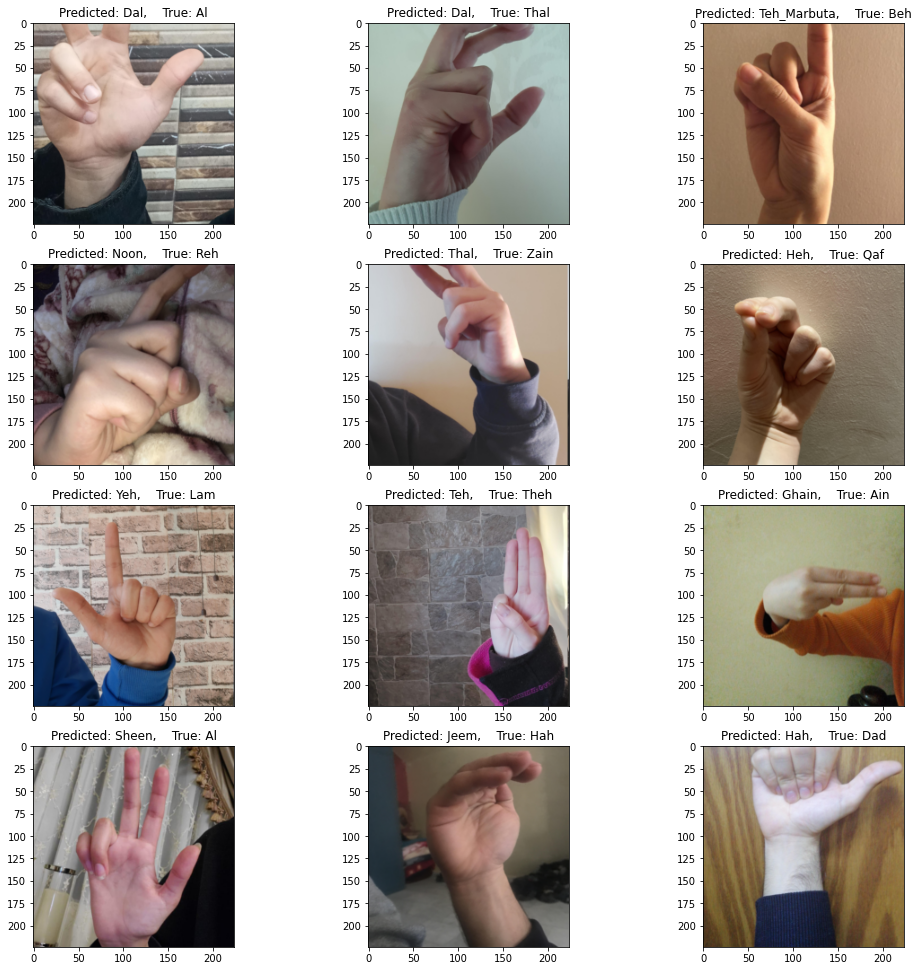

In [85]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[32:44]):
    plt.subplot(4,3,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


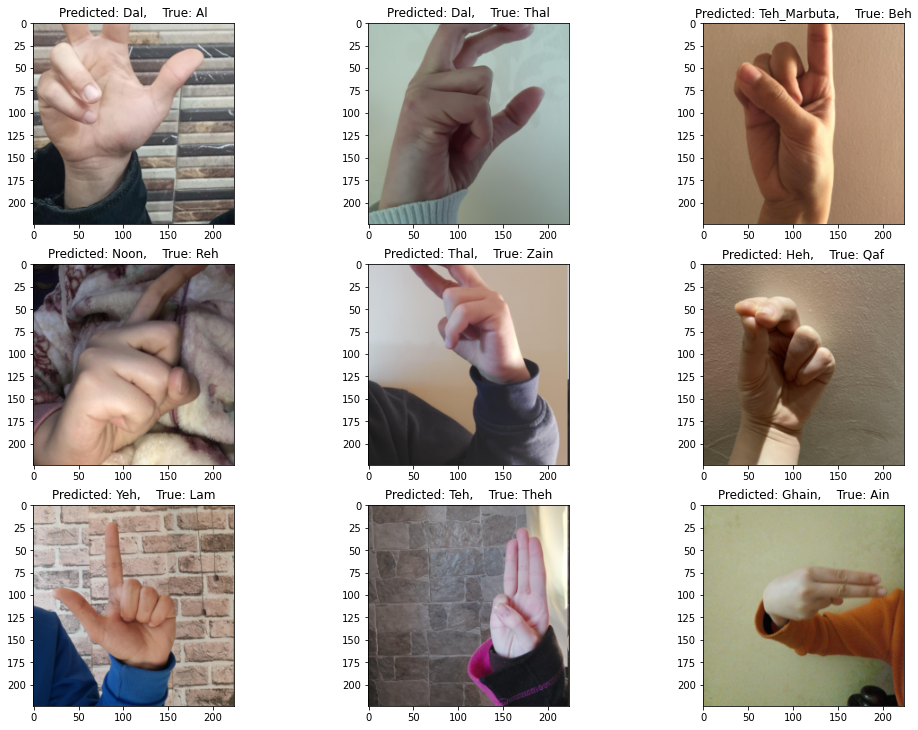

In [86]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[45:54]):
    plt.subplot(4,3,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


## Plot the confusion matrix 

In [87]:
dic_class_idx = traindataset.dataset.class_to_idx
dic_class_idx

{'Ain': 0,
 'Al': 1,
 'Alef': 2,
 'Beh': 3,
 'Dad': 4,
 'Dal': 5,
 'Feh': 6,
 'Ghain': 7,
 'Hah': 8,
 'Heh': 9,
 'Jeem': 10,
 'Kaf': 11,
 'Khah': 12,
 'Laa': 13,
 'Lam': 14,
 'Meem': 15,
 'Noon': 16,
 'Qaf': 17,
 'Reh': 18,
 'Sad': 19,
 'Seen': 20,
 'Sheen': 21,
 'Tah': 22,
 'Teh': 23,
 'Teh_Marbuta': 24,
 'Thal': 25,
 'Theh': 26,
 'Waw': 27,
 'Yeh': 28,
 'Zah': 29,
 'Zain': 30}

In [88]:
idx_to_class_dic = {v: k for k, v in dic_class_idx.items()}

In [89]:
idx_to_class_dic

{0: 'Ain',
 1: 'Al',
 2: 'Alef',
 3: 'Beh',
 4: 'Dad',
 5: 'Dal',
 6: 'Feh',
 7: 'Ghain',
 8: 'Hah',
 9: 'Heh',
 10: 'Jeem',
 11: 'Kaf',
 12: 'Khah',
 13: 'Laa',
 14: 'Lam',
 15: 'Meem',
 16: 'Noon',
 17: 'Qaf',
 18: 'Reh',
 19: 'Sad',
 20: 'Seen',
 21: 'Sheen',
 22: 'Tah',
 23: 'Teh',
 24: 'Teh_Marbuta',
 25: 'Thal',
 26: 'Theh',
 27: 'Waw',
 28: 'Yeh',
 29: 'Zah',
 30: 'Zain'}

In [90]:
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

In [91]:
label_flattened  = flatten(labels_list)
logits_flattened = flatten(logits_list)

In [92]:
cmt = torch.zeros((31,31), dtype=int)
np_arr = cmt.detach().numpy()

In [93]:
for i,_ in enumerate(label_flattened):
   tl = label_flattened[i] 
   pl = logits_flattened[i]
   np_arr[tl,pl] = np_arr[tl,pl] + 1 

In [94]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    cbar = plt.colorbar(fraction=0.0457, pad=0.04)
    cbar.ax.tick_params(labelsize=40)

    
    tick_marks = np.arange(len(classes))

                        #  {'ain'   'al': 'aleff': 'bb': 'dal' 'dha' ,'dhad'  ,'fa', 'gaaf' 'ghain'  'ha'   'haa'  'jeem' 'kaaf' 'khaa'   'la'  'laam'  'meem'  'nun'   'ra'   saad'  'seen'  'sheen'  'ta'  'taa'   'thaa'  'thal'     'toot'      'waw'   'ya': 29          'yaa'   'zay'}
    plt.xticks(tick_marks, [r'Ain',r'Al',r'Alef',r'Beh',r'Dad',r'Dal',r'Feh',r'Ghain',r'Hah', r'Heh', r'Jeem',r'Kaf',r'Khah',r'Laa',r'Lam',r'Meem',r'Noon',r'Qaf',r'Reh',r'Sad',r'Seen',r'Sheen',r'Tah',r'Teh',r'Teh_Marbuta', r'Thal',r'Theh',r'Waw',r'Yeh',r'Zah',r'Zain'],fontsize=80 , rotation=90, fontweight='bold')
    plt.yticks(tick_marks,[r'Ain',r'Al',r'Alef',r'Beh',r'Dad',r'Dal',r'Feh',r'Ghain',r'Hah',r'Heh', r'Jeem',r'Kaf',r'Khah',r'Laa',r'Lam',r'Meem',r'Noon',r'Qaf',r'Reh',r'Sad',r'Seen',r'Sheen',r'Tah',r'Teh',r'Teh_Marbuta',r'Thal', r'Theh',r'Waw',r'Yeh',r'Zah',r'Zain'] ,fontsize=80, fontweight='bold')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=35, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel(r'\bf{True label}', fontsize=40, labelpad=10,fontweight='bold')
    plt.xlabel(r'\bf{Predicted label}', fontsize=40, labelpad=10,fontweight='bold')


Confusion matrix, without normalization
[[36  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 37  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0
   0  0  0  0  1  0  0]
 [ 0  0 41  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 40  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  2
   1  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  2  0  0]
 [ 0  0  0  0  1 28  0  0  1  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0
   0  3  0  0  0  0  0]
 [ 0  0  0  0  1  0 28  0  0  2  0  0  1  0  1  0  0  3  0  1  0  0  0  0
   1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0 33  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0 35  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 35  0  0  0  0  0  0  0  2  0  0  0  0  0  0
   1

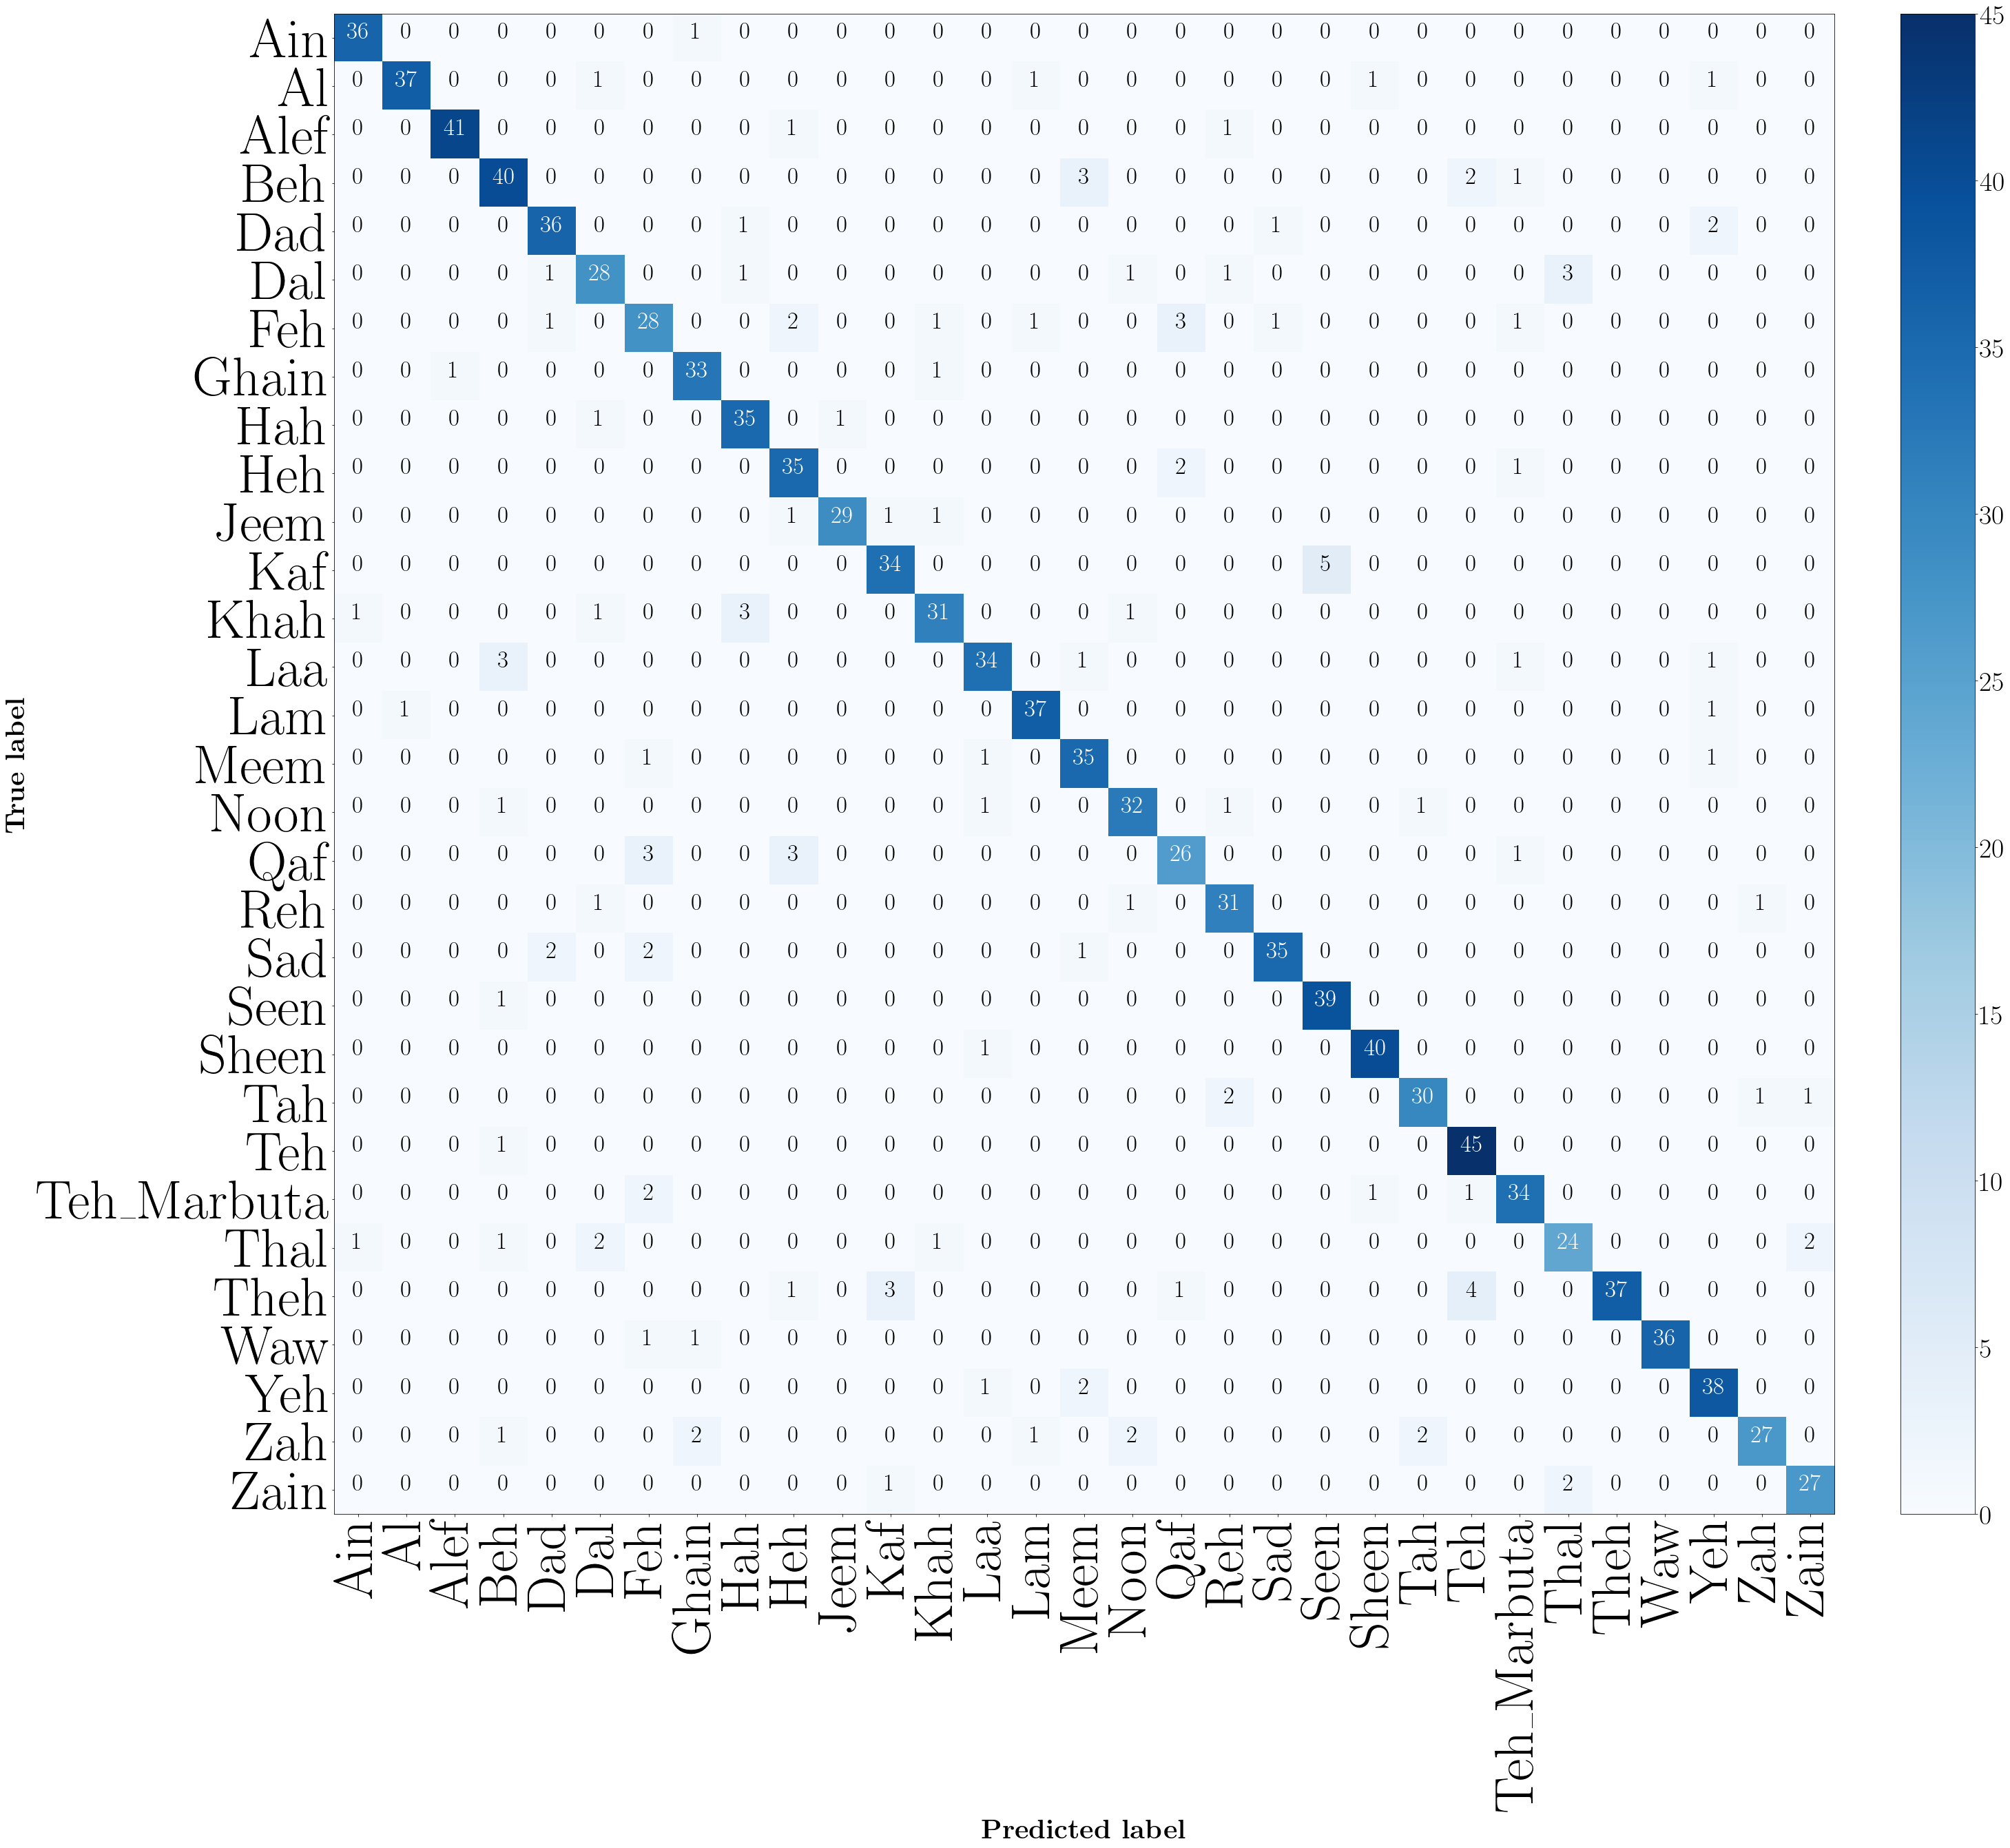

In [95]:
from sklearn.metrics import confusion_matrix
import matplotlib as mpl


plt.rcParams.update({ "text.usetex": True})


mpl.rcParams['font.family'] = 'cmu serif'
mpl.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(40,40))

plot_confusion_matrix(np_arr,dataset.classes)

print(dataset.classes)

plt.savefig(f"CM_{tensor_baord_variable}", format="pdf", dpi= 400, bbox_inches='tight')
